In [4]:
from matplotlib import pyplot as plt
import os
import torch
import segmentation_models_pytorch as smp
from recognition.model import RecognitionModel
import torchvision
import utils
import cv2
import numpy as np
from detection import unet

In [6]:
cur_dir = os.path.abspath('.')

In [7]:
data_path = '../data'

In [8]:
cur_dir

'/home/ubuntu/contest2'

In [9]:
seg_model_path = os.path.join(cur_dir, 'detection/output', 'fpn_se_resnet50_4+_CP-best_epoch-3.pth')
# seg_model_path = os.path.join(cur_dir, 'pretrained/', 'seg_unet_20epoch_basic.pth')
rec_model_path = os.path.join(cur_dir, 'recognition/output', 'crnn_resnet34_cp-best.pth')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
seg_model = smp.FPN('se_resnet50', encoder_weights='imagenet', classes=2)
# seg_model = unet.UNet()
seg_model.load_state_dict(torch.load(seg_model_path))
seg_model.to(device)
seg_model.eval()

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

In [12]:
recognition_model = RecognitionModel(input_size=(320, 64), dropout=0.1, num_directions=2) # TODO: obtain parameters from torch.load
recognition_model.load_state_dict(torch.load(rec_model_path))
recognition_model.to(device)
recognition_model.eval()

RecognitionModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [13]:
test_dir_path = os.path.join(data_path, 'test')

In [14]:
w, h = list(map(int, '320x64'.split('x')))
def ocr_preprocess(image, output_size):
    image = cv2.resize(image, output_size, interpolation=cv2.INTER_AREA)
    image = image.astype(np.float) / 255.
    return torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)

In [15]:
image_size = (640, 640)

In [16]:
def test():
    results = []
    seg_threshold = 0.5
    with torch.no_grad():
        files = os.listdir(test_dir_path)
        np.random.shuffle(files)
        for i, file_name in enumerate(files):
            image_src = cv2.imread(os.path.join(test_dir_path, file_name))
            img, k, dw, dh = utils.prepare_for_inference(image_src.astype(np.float) / 255., image_size,)
                                                  #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # TODO: obtain sizes from torch.load
            input = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0)

            pred = torch.sigmoid(seg_model(input.to(device))[:, 0]).squeeze().cpu().numpy()
            mask = (pred >= seg_threshold).astype(np.uint8)# * 255
            boxes = utils._get_boxes_from_mask(mask, dw, dh, k)
            
            if len(boxes) == 0:
                print('no_boxes')
                results.append((file_name, []))
                continue
            yield mask, boxes
            texts = []
#             yield boxes
            for box in boxes:
                box[:, 0] = box[:, 0].clip(0, image_src.shape[1] - 1)
                box[:, 1] = box[:, 1].clip(0, image_src.shape[0] - 1)
                x1 = box[0][0]
                crop = utils.crop_bounding_box(image_src, box)
                tensor = ocr_preprocess(crop, (w, h)).to(device)
                text = recognition_model(tensor, decode=True)[0]
                texts.append((x1, text))
                yield crop, text, img, image_src, dw, dh, k
            # all predictions must be sorted by x1
            texts.sort(key=lambda x: x[0])
            results.append((file_name, [w[1] for w in texts]))
            if i % 100 == 0:
                print(i, len(files))


In [17]:
test_gen = test()

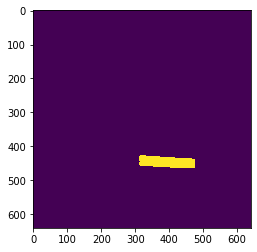

In [50]:
mask, boxes = next(test_gen)
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A598OY27


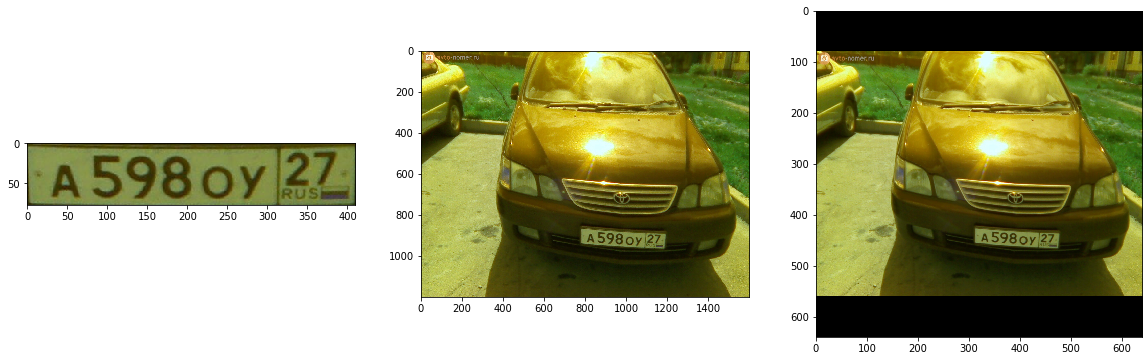

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
# boxes = next(test_gen)
crop, text, img, image_src, dw, dh, k = next(test_gen)
ax[0].imshow(crop)
ax[1].imshow(image_src)
ax[2].imshow(img)
print(text)